In [137]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import scipy 
import scipy.stats as ss
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
sys.path.append('../Script/')
import FM_States
import FM_selection
import TF
import Drug_response
import Query


ROOT_DIR = os.path.abspath("../")

In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

In [139]:
para = {
    'output_dir': ROOT_DIR+"/Sample_output/Example3/",
    'input_dir': ROOT_DIR+"/Sample_input/Example3/"
}

In [140]:
matrix_factor = pd.read_csv(para['output_dir'] +"/matrix_factor_brca_gdsc.csv", index_col= "Unnamed: 0")
Drug_IC50 = pd.read_csv(para['input_dir'] +"Drug_IC50_matrix.csv", index_col= "Unnamed: 0") #This includes all drugs and all cell lines
Drug_AUC = pd.read_csv(para['input_dir'] +"Drug_AUC_matrix.csv", index_col= "Unnamed: 0")
DrugInformation = pd.read_csv(para['input_dir'] + '/Drug_annotation.csv', index_col= "Unnamed: 0")
BRCA_expression = pd.read_csv(para['output_dir'] +"matrix_exp_brca_gdsc.csv",index_col= "Unnamed: 0")

In [141]:
output_dir = para['output_dir']
BRCA_cellLine = list(matrix_factor.index.values)

cell_lines_Brca = list(set(Drug_IC50.columns.tolist()).intersection(set(Drug_response.convert(BRCA_cellLine))))
Drug_IC50[Drug_response.convert(cell_lines_Brca)]
Drug_IC50_new = Drug_IC50[Drug_response.convert(cell_lines_Brca)]

effect_drugs = (Drug_response.effective_drugs(Drug_IC50[Drug_response.convert(cell_lines_Brca)], 0.1)) #0.1 means 10 percent of samples show IC50 values smaller than -1
drug_matrix = Drug_IC50.loc[effect_drugs]
drug_matrix_brca = drug_matrix[Drug_response.convert(cell_lines_Brca)]
drug_matrix_new = drug_matrix_brca[Drug_response.convert(list(matrix_factor.index.values))]


In [142]:
def convert_toInt(list): 
    res = []
    # Converting integer list to string list 
    for i in list:
        res.append(int(i)) 
    return(res)

def convert(list): 
    res = []
    # Converting integer list to string list 
    for i in list:
        res.append(str(i)) 
    return(res)

In [160]:
df_acc_E = pd.DataFrame()
df_acc_F = pd.DataFrame()

accuracy_F = []
accuracy_E = []
   
    
for drug in effect_drugs:
    y = Drug_IC50_new[convert(BRCA_cellLine)].loc[drug] 
    y = y.loc[y.isna()==False]
    samples = y.index.values.tolist()
    data = matrix_factor.loc[convert_toInt(samples)]
    #data
    # fac = cor_matrix_sig.loc[drug]
    fac_used = matrix_factor.columns.tolist()
    X = data[fac_used]
    X = X[list((set(X.columns)) - set(['States']))]
    
    y = y
    y[y > -1] = 1
    y[y < -1] = 0
    
    X_E = BRCA_expression
    #print(drug)
    
    X_train_F, X_test_F, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
    #for i in range(0,20):
    #    X_train_F, X_test_F, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
    X_train_E = X_E.loc[(list(X_train_F.index.to_list()))]
    X_test_E = X_E.loc[(list(X_test_F.index.to_list()))]
        

    clf_F = RandomForestClassifier(n_estimators = 100, max_depth=None,
                                              random_state=None)
        
    clf_F.fit(X_train_F, y_train)
    scores = clf_F.score(X_test_F, y_test)


    clf_E = RandomForestClassifier(n_estimators = 100, max_depth=None,
                                              random_state=None)
    clf_E.fit(X_train_E, y_train)
    scores_E = clf_E.score(X_test_E, y_test)
        
    accuracy_F.append(scores)
    accuracy_E.append(scores_E)

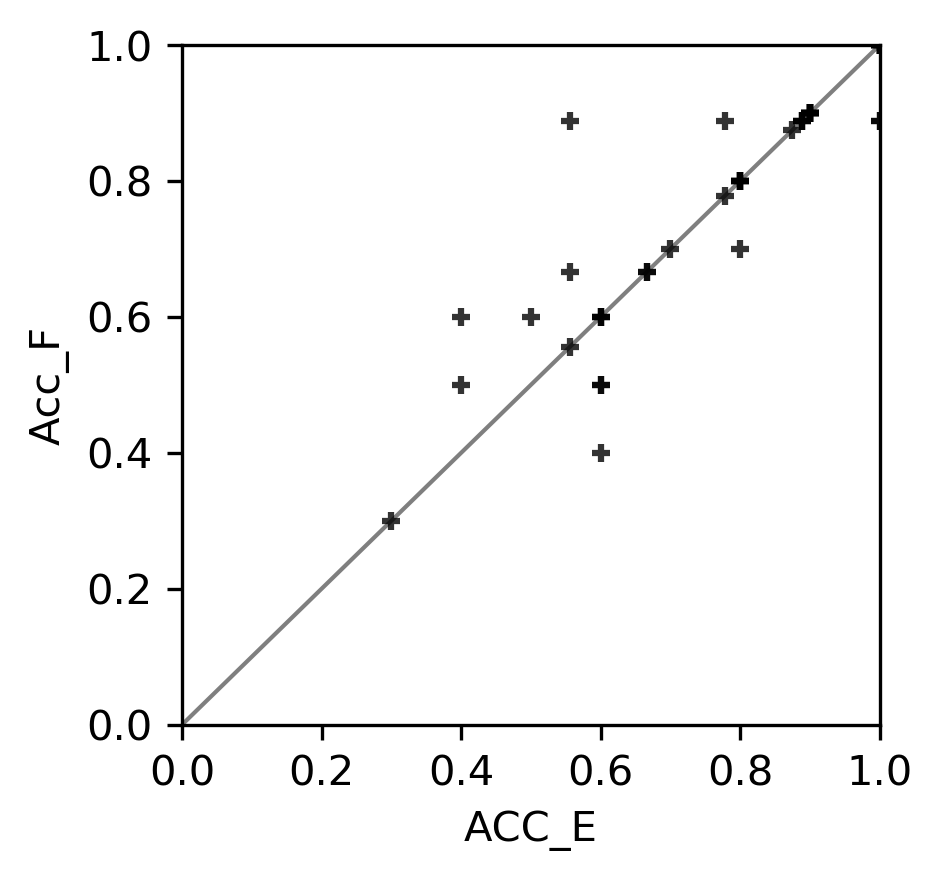

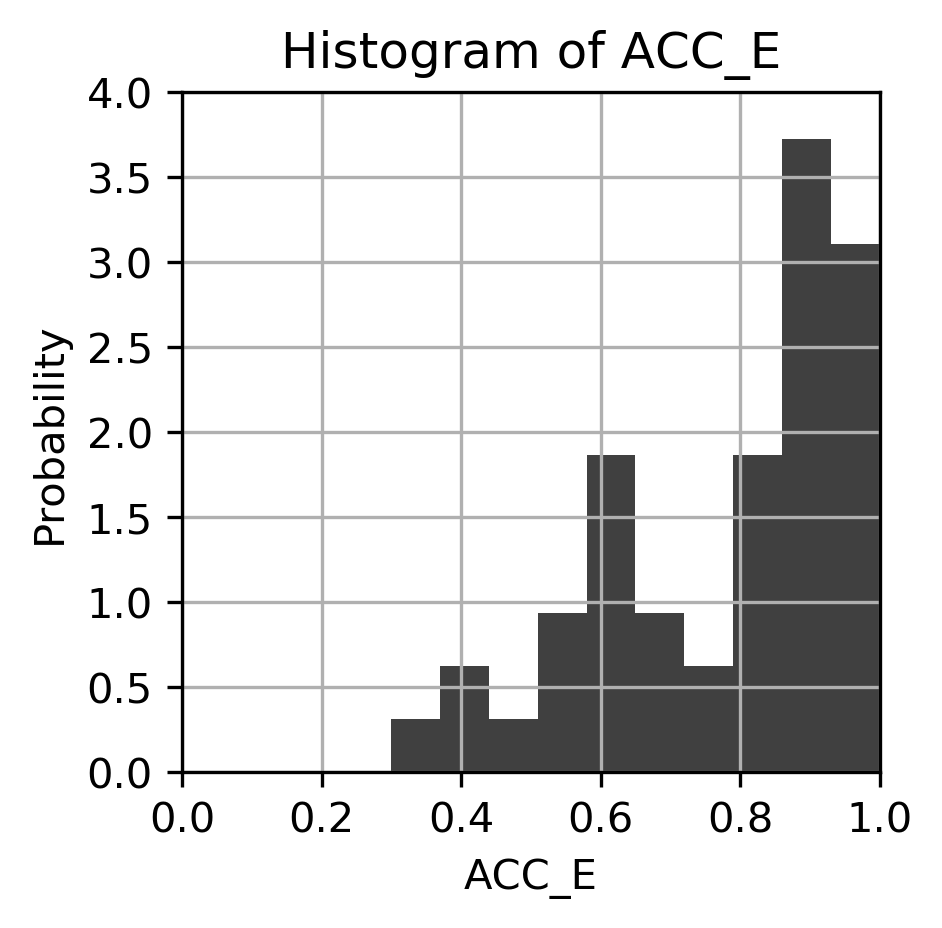

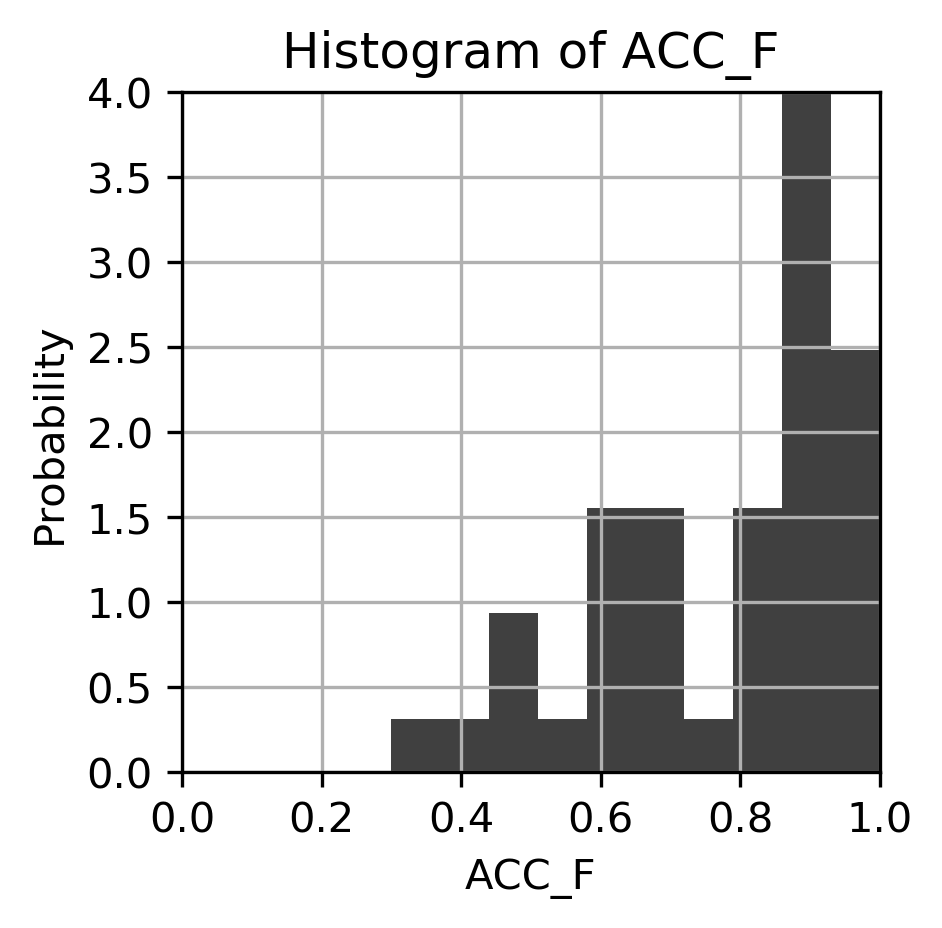

In [161]:
result = pd.DataFrame({'Drug':effect_drugs, 'Acc_F':accuracy_F, 'Acc_E':accuracy_E })
result.to_csv(para['output_dir'] + "accuracy.csv")

import matplotlib.pyplot as plt
import numpy as np
plt.figure(num=None, figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')

x = result['Acc_E']
y = result['Acc_F']

plt.scatter(x, y, s=20, c="k", alpha=0.8, marker='+')
plt.xlabel("ACC_E")
plt.ylabel("Acc_F")
plt.xlim((0, 1))
plt.ylim((0, 1))

xrange = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
yrange = xrange
plt.plot(xrange, yrange, 'k-', alpha=0.5, linewidth=1)
plt.show()


import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.figure(num=None, figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')

x = result['Acc_E']

# the histogram of the data
n, bins, patches = plt.hist(x, 10, density=True, facecolor='k', alpha=0.75)


plt.xlabel('ACC_E')
plt.ylabel('Probability')
plt.title('Histogram of ACC_E')
plt.xlim(0, 1)
plt.ylim(0, 4)
plt.grid(True)
plt.show()

plt.figure(num=None, figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')

x = result['Acc_F']

# the histogram of the data
n, bins, patches = plt.hist(x, 10, density=True, facecolor='k', alpha=0.75)


plt.xlabel('ACC_F')
plt.ylabel('Probability')
plt.title('Histogram of ACC_F')
plt.xlim(0, 1)
plt.ylim(0, 4)
plt.grid(True)
plt.show()